# Conformalized Survival Regression

In this notebook we'll explore survival prediction in a classical setting, survival prediction under incomplete censoring times, and our proposed remidy for incomplete censoring times, using our novel technique.

First we need a baseline. In the classical case of Type I censoring, for every patient there is a triplet $(X,C,T)$, of which we have access to $(X,\tilde{T}=C\wedge T, T)$.
We'll use the same random generation process as Candes et. al.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
import sys
%matplotlib inline

from sklearn.model_selection import train_test_split
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.util import Surv
from sklearn.dummy import DummyRegressor



In [2]:
n_samples = 10000
X_uni = np.random.uniform(low=0.0, high=4.0, size=n_samples)
X_uni.sort()
X_multi = np.random.uniform(low=-1.0, high=1.0, size=(n_samples, 100))
C = np.random.exponential(4, size=n_samples)
mu_uni = 2 + 0.37 * np.sqrt(X_uni)
sd_uni_homo = 1.5
sd_uni_hetero = 1 + X_uni/5
T_uni_homo = np.exp(np.random.normal(loc=mu_uni, scale=sd_uni_homo, size=n_samples))
T_tilde_uni_homo = Surv.from_arrays((T_uni_homo < C), np.minimum(T_uni_homo, C))
T_uni_hetero = np.exp(np.random.normal(loc=mu_uni, scale=sd_uni_hetero, size=n_samples))
T_tilde_uni_hetero = Surv.from_arrays((T_uni_hetero < C), np.minimum(T_uni_hetero, C))
T_tilde_uni_hetero = np.minimum(T_uni_hetero, C)
mu_multi = np.log(2) + 1 + 0.55 * (X_multi[:,0]**2 + X_multi[:,2] * X_multi[:,4])
sd_multi_homo = 1
sd_multi_hetero = np.abs(X_multi[:,9]) + 1
T_multi_homo = np.exp(np.random.normal(loc=mu_multi, scale=sd_multi_homo, size=n_samples))
T_tilde_multi_homo = Surv.from_arrays((T_multi_homo < C), np.minimum(T_multi_homo, C))
T_multi_hetero = np.exp(np.random.normal(loc=mu_multi, scale=sd_multi_hetero, size=n_samples))
T_tilde_multi_hetero = Surv.from_arrays((T_multi_hetero < C), np.minimum(T_multi_hetero, C))

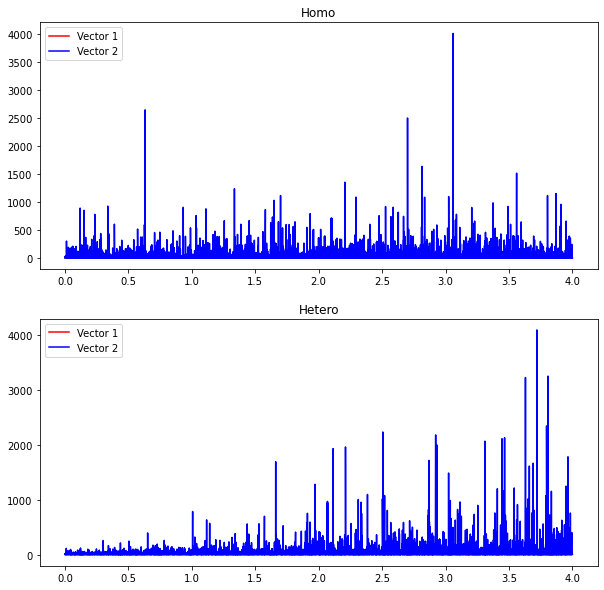

In [3]:
data_uncensored = [
    (X_uni, C, T_uni_homo),
    (X_uni, C, T_uni_hetero)
]

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Flattening the axes array for easier iteration
axs = axs.flatten()

for i in range(2):
    x, y1, y2 = data_uncensored[i]
    axs[i].plot(x, y1, color="red", label='Vector 1')
    axs[i].plot(x, y2, color="blue", label='Vector 2')
    axs[i].legend(loc='upper left')

axs[0].set_title("Homo")
axs[1].set_title("Hetero")
plt.show()

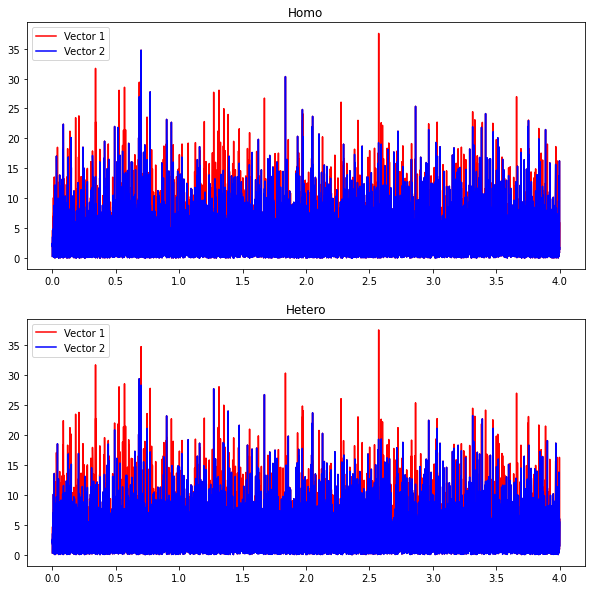

In [4]:
data_censored = [
    (X_uni, C, np.minimum(T_uni_homo, C)),
    (X_uni, C, np.minimum(T_uni_hetero, C))
]

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Flattening the axes array for easier iteration
axs = axs.flatten()

for i in range(2):
    x, y1, y2 = data_censored[i]
    axs[i].plot(x, y1, color="red", label='Vector 1')
    axs[i].plot(x, y2, color="blue", label='Vector 2')
    axs[i].legend(loc='upper left')

axs[0].set_title("Homo")
axs[1].set_title("Hetero")
plt.show()

In [19]:
alpha = 0.1
betas = np.array([beta/10.0 for beta in range(1, 10, 1)])
X_uni_train, X_uni_test, C_train, C_test, T_uni_homo_train, T_uni_homo_test = train_test_split(X_uni, C, T_tilde_uni_homo)
_, _, _, _,  T_uni_hetero_train, T_uni_hetero_test = train_test_split(X_uni, C, T_tilde_uni_hetero)
X_multi_train, X_multi_test, _, _,  T_multi_hetero_train, T_multi_hetero_test = train_test_split(X_multi, C, T_tilde_multi_hetero)
_, _, _, _,  T_multi_homo_train, T_multi_homo_test = train_test_split(X_multi, C, T_tilde_multi_homo)

# Uninvariate Homoscedastic

In [20]:
T_uni_homo_est = GradientBoostingSurvivalAnalysis(loss="pinball", beta=1-alpha, learning_rate=0.1, max_depth=1, random_state=0)
T_uni_homo_est.fit(X_uni_train.reshape(-1,1), T_uni_homo_train)
C_uni_homo_est = [DummyRegressor(strategy="quantile", quantile=b) for b in betas]
for i, b in enumerate(betas):
    C_uni_homo_est[i].fit(X_uni_train.reshape(-1,1), C_train)

In [34]:
def non_conformity(y, y_hat):
    return y["time"] - y_hat

def estimate_weights(betas, c_est, c_0):
    # Step 1: Find where c_est > c_0
    greater_than_c0 = c_est > c_0

    # Step 2: Find the index of the first True value in each row
    first_true_indices = (greater_than_c0.cumsum(axis=1) == 1).argmax(axis=1)

    # Step 3: Select the corresponding betas
    result = betas[first_true_indices]

    return 1.0/(1.0 - result)

print(estimate_weights(np.array([0.1, 0.5 ,0.9]), np.array([[1, 2 ,3], [1, 3 ,5]]), 2.5)) # [10.  2.]

def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

[10.  2.]


0.09999999999999998